# parsing configuration file

In [2]:
import configparser
confParser = configparser.ConfigParser()

In [3]:
#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())

conf. file sections: ['parameters', 'flags', 'MsdAnalysis', 'EnergyBarrier', 'SroAnalysis', 'input files', 'Atomic Radius', 'Vacancy Dynamics']


# import libraries

In [4]:
import sys
sys.path.append(confParser['input files']['lib_path'])

#--- system libraries
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
from scipy.interpolate import InterpolatedUnivariateSpline
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
from functools import reduce
import time
import fnmatch
from scipy.optimize import curve_fit

#
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#--- user modules
import LammpsPostProcess as lp
#import LammpsPostProcess2nd as lpp
#import utilityy as utll
import utility as utl
#from utility import *
import imp
#imp.reload(lpp)
imp.reload(utl)
imp.reload(lp)
#imp.reload(utll)

<module 'LammpsPostProcess' from '../../HeaDef/postprocess/LammpsPostProcess.py'>

In [6]:
class Symbols:
    def __init__(self,
                markersizes=[10,10,10,12,12,12,10],
                ):
        self.colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
        self.fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
        self.markers=['o','s','D','^','<','>','v']
        self.markersizes=markersizes
        self.nmax=7
        
    def GetAttrs(self,count=0,label='',nevery=1,fmt='.-',zorder=1,alpha=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':self.colors[count],
            'markeredgecolor':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
             'zorder':zorder,
               'alpha':alpha
         }
        return attrs
    
    def GetAttrs2nd(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        '''
        empty symbols
        '''
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':'white',
#            'markeredgecolor':'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
            'zorder':zorder,
          }
        return attrs

    def GetAttrsScatter(self,count=0,label='',nevery=1,fmt='.-',zorder=1,alpha=0.5):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            's':self.markersizes[count],
            'marker':self.markers[count],
#            'markerfacecolor':self.colors[count],
            'edgecolors':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
#            'markevery':nevery,
#           'errorevery':nevery,
#            'markeredgewidth':1.75,
            'linewidth':1, 
#            'barsabove':None,
#            'capsize':5,
#            'capthick':1,
#            'elinewidth':1,
#            'fmt':fmt,
             'zorder':zorder,
               'alpha':alpha
         }
        return attrs
    
    
class Legends:
    def __init__(self
                ):
        pass
    def Set(self,fontsize=20,
                 labelspacing=0,
                 **kwargs
#                 bbox_to_anchor=(0.5,0.48,0.5,0.5),
           ):
        self.attrs = {'frameon':False,'fontsize':fontsize,
                   'labelspacing':labelspacing,
                      'handletextpad':.2,
                   'handlelength':1,
                    **kwargs,
                     }
    def Get(self):
        return self.attrs

DRAW_FRAME=(0.23,0.08,0.12,0.07,0.01)
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    

## arrhenius law

In [8]:
class Temperature:
    def __init__(self,temp_range,nrun,verbose=False):
        self.temps =  temp_range
        self.nrun = nrun
        self.verbose = verbose
#         pdb.set_trace()
#        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],np.arange(x[1])),
#            zip(self.temps,self.nrun))))

        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],x[1]),
             zip(self.temps,self.nrun))))
        
    
    def BuildTempRealizationPair(self,temps,nrun):
        t,r=np.meshgrid(temps,nrun,indexing='ij')
        return np.array(list(zip(t.flatten(),r.flatten())))
        
    def ModifyNrun(self,dirs):
        #--- modify dirs
        count = -1
        dirs_copy = dirs[:]
        for _, indx in zip(self.temps,range(len(self.temps))):
            nrun_mod = self.nrun[indx][:]
            for y in self.nrun[indx]:
                count += 1
                x = dirs[count]
                if not os.path.isfile(x): #--- if false: remove file from "dirs"
                    dirs_copy.remove(x)
                    nrun_mod.remove(y)
            self.nrun[indx] = nrun_mod[:]

            assert len(self.nrun[indx]) > 0, 'temp = %s has no data!'%(self.temps[indx])
                
        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],x[1]),
             zip(self.temps,self.nrun))))
        return dirs_copy
        
    def Parse(self,dirs):
            
        dirs = self.ModifyNrun(dirs)
#         print('dirs:',dirs)
        self.data=list(map(lambda x:np.loadtxt(x,ndmin=2),dirs))
        if self.verbose:
            n = np.array(self.nrun).flatten()
            list(map(lambda x:print('Parsing: %s data.shape is: %s'%(x[1],x[0].shape)),zip(self.data,n)))
#        print('np.array(self.data):',np.array(self.data))

        
    def Plot(self,             colorIndices, labels, **kwargs):
#        print(list(self.temps_runs))
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5)
                   )
        for data, temp_run, count, indx in zip(self.data,self.temps_runs,range(len(self.data)),colorIndices): 
            temp = temp_run[0]
            try:
                utl.PltErr(data[:,0],data[:,1],
                       yerr=data[:,2],
                       ax = self.ax,
                       attrs=symbols.GetAttrs(count=indx%7,label=labels[count]),
                       Plot=False,
                      )
            except:
                continue
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                    Plot=False,
                   DrawFrame=DRAW_FRAME,
#                  legend=legends.Get(),
                   **kwargs
                  )



    def Binning(self,tr_mat,bins_per_decade, nmin=1, LogScale=True):
        (tij, xij, yij, zij, xij_sq, yij_sq, zij_sq, nij, _) = tr_mat.T
        #--- binning
        tmin       = 0.99*tij.min()
        tmax       = 1.01*tij.max()        
        if LogScale:
            n_decades  = int(np.ceil(np.log10(tmax/tmin)))
            bins       = np.logspace(np.log10(tmin),np.log10(tmax),n_decades*bins_per_decade)
        else:
            bins       = np.linspace(tmin,tmax,32)
            
            
        #
        count, _   = np.histogram(tij,bins=bins,weights=nij)
        tsum,  _   = np.histogram(tij,bins=bins,weights=nij*tij)
        filtr      = count >= nmin * nij[ 0 ]
        #  
        xsum, _    = np.histogram(tij,bins=bins,weights=xij)
        ysum, _    = np.histogram(tij,bins=bins,weights=yij)
        zsum, _    = np.histogram(tij,bins=bins,weights=zij)

        xsum_sq, _ = np.histogram(tij,bins=bins,weights=xij_sq)
        ysum_sq, _ = np.histogram(tij,bins=bins,weights=yij_sq)
        zsum_sq, _ = np.histogram(tij,bins=bins,weights=zij_sq)
        #
        xsum       = xsum[filtr]
        ysum       = ysum[filtr]
        zsum       = zsum[filtr]
        #
        xsum_sq    = xsum_sq[filtr]
        ysum_sq    = ysum_sq[filtr]
        zsum_sq    = zsum_sq[filtr]
        #
        tsum       = tsum[filtr]
        count      = count[filtr]
        print('count=',count)
        assert not np.any(count < nmin * nij[ 0 ] ), 'incerease bin size!'
        #
        xsum_sq   /= count
        ysum_sq   /= count
        zsum_sq   /= count
        #
        xsum      /= count
        ysum      /= count
        zsum      /= count
        #     
        tsum      /= count
        #
        xsum_sq   -= (xsum * xsum)
        ysum_sq   -= (ysum * ysum)
        zsum_sq   -= (zsum * zsum)
        assert np.all(xsum_sq >= 0) and np.all(ysum_sq >= 0) and np.all(zsum_sq >= 0)
        #
        var        = xsum_sq + ysum_sq + zsum_sq
#        assert not np.any(ysum_sq < 0.0), 'print %s'%ysum_sq
        
        return np.c_[tsum,var, var*np.sqrt(2.0/count) ] 

    def Binning3rd(self,tr_mat,bins_per_decade, nmin=1):
        #--- binning
        xmin       = 0.99*tr_mat[:,0].min()
        xmax       = 1.01*tr_mat[:,0].max()
        n_decades  = int(np.ceil(np.log10(xmax/xmin)))
        bins       = np.logspace(np.log10(xmin),np.log10(xmax),n_decades*bins_per_decade)
        
        tdata = tr_mat[:,0]
        xdata = tr_mat[:,1]
        ydata = tr_mat[:,2]
        zdata = tr_mat[:,3]
        tdata_concat = np.concatenate([tdata,tdata,tdata])
        rdata_concat = np.concatenate([xdata,ydata,zdata])
        #
        count, _   = np.histogram(tdata_concat,bins=bins)
        tsum,  _   = np.histogram(tdata_concat,bins=bins,weights=tdata_concat)
        filtr      = count >= nmin
        #  
        rsum, _    = np.histogram(tdata_concat,bins=bins,weights=rdata_concat)

        rsum_sq, _ = np.histogram(tdata_concat,bins=bins,weights=rdata_concat*rdata_concat)
        #
        rsum       = rsum[filtr]
        #
        rsum_sq    = rsum_sq[filtr]
        #
        tsum       = tsum[filtr]
        count      = count[filtr]
        assert not np.any(count < nmin), 'incerease bin size!'
        #
        rsum_sq   /= count
        #
        rsum      /= count
        #     
        tsum      /= count
        #
        rsum_sq   -= (rsum * rsum)
#         assert np.all(xsum_sq >= 0) and np.all(ysum_sq >= 0) and np.all(zsum_sq >= 0)
        #
        var        = rsum_sq / 3.0
#        assert not np.any(ysum_sq < 0.0), 'print %s'%ysum_sq
        
        return np.c_[tsum,var,  np.sqrt(2.0/count) * var ] 

    def Binning4th(self,tr_mat, nmin=2):
        (_, xij, yij, zij, xij_sq, yij_sq, zij_sq, nij, tij) = tr_mat.T
        #--- binning
        tmin       = tij.min()
        tmax       = tij.max() + 1        
        bins=np.arange(tmin-0.5,tmax+0.5,1.0)
            
        #
        count, _   = np.histogram(tij,bins=bins,weights=nij)
        tsum,  _   = np.histogram(tij,bins=bins,weights=nij*tij)
        filtr      = count >= nmin * nij[ 0 ]
        #  
        xsum, _    = np.histogram(tij,bins=bins,weights=xij)
        ysum, _    = np.histogram(tij,bins=bins,weights=yij)
        zsum, _    = np.histogram(tij,bins=bins,weights=zij)

        xsum_sq, _ = np.histogram(tij,bins=bins,weights=xij_sq)
        ysum_sq, _ = np.histogram(tij,bins=bins,weights=yij_sq)
        zsum_sq, _ = np.histogram(tij,bins=bins,weights=zij_sq)
        #
        xsum       = xsum[filtr]
        ysum       = ysum[filtr]
        zsum       = zsum[filtr]
        #
        xsum_sq    = xsum_sq[filtr]
        ysum_sq    = ysum_sq[filtr]
        zsum_sq    = zsum_sq[filtr]
        #
        tsum       = tsum[filtr]
        count      = count[filtr]
        assert not np.any(count < nmin * nij[ 0 ] ), 'incerease bin size!'
        #
        xsum_sq   /= count
        ysum_sq   /= count
        zsum_sq   /= count
        #
        xsum      /= count
        ysum      /= count
        zsum      /= count
        #     
        tsum      /= count
        #
        xsum_sq   -= (xsum * xsum)
        ysum_sq   -= (ysum * ysum)
        zsum_sq   -= (zsum * zsum)
        assert np.all(xsum_sq >= 0) and np.all(ysum_sq >= 0) and np.all(zsum_sq >= 0)
        #
        var        = xsum_sq + ysum_sq + zsum_sq
#        assert not np.any(ysum_sq < 0.0), 'print %s'%ysum_sq
        
        return np.c_[tsum,var, var*np.sqrt(2.0/count) ] 


    def EnsAverage2nd(self,
                   log_scale_x=False,log_scale_y=False,
                   col_x=0,col_y=1,
                   n_bins_per_decade=6,
                  n_thresh=0,
                   ymin=-sys.maxsize,ymax=sys.maxsize,
                      tmax=sys.maxsize
                  ):
        kount = 0
        self.data_averaged = {} 
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            nruns = len(self.nrun[indx])
            data = self.data[kount:kount+nruns]
    
            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
    
            data = np.concatenate(np.array(data)[filtr]) #,axis=0)
            if self.verbose:
                print('data.shape:',np.array(data).shape)
#             pdb.set_trace()
            filtr = np.all( [ data[ :, 0 ] > 0.0, data[ :, 0 ] <= tmax ], axis = 0 )
            self.data_averaged[ temp ] = self.Binning(data[filtr],n_bins_per_decade,nmin=n_thresh, LogScale = log_scale_x )

            kount += nruns

    def EnsAverage3rd(self,
                  n_thresh=2,
                      tmax=sys.maxsize,
                      ReturnConcat = False
                  ):
        kount = 0
        self.data_averaged = {} 
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            nruns = len(self.nrun[indx])
            data = self.data[kount:kount+nruns]
    
            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
    
            data = np.concatenate(np.array(data)[filtr]) #,axis=0)
            if self.verbose:
                print('data.shape:',np.array(data).shape)
#             pdb.set_trace()
            filtr = data[:,0] <= tmax
            if ReturnConcat:
                self.data_averaged[ temp ] = data[filtr]
            else:
                self.data_averaged[ temp ] = self.Binning4th(data[filtr],nmin=n_thresh )

            kount += nruns

            
    def EnsAverage(self,
                   log_scale_x=False,log_scale_y=False,
                   col_x=0,col_y=1,
                   n_bins_per_decade=6,
                  n_thresh=0,
                   ymin=-sys.maxsize,ymax=sys.maxsize
                  ):
        kount = 0
        self.data_averaged = {} #np.zeros(len(self.temps))
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            nruns = len(self.nrun[indx])
            data = self.data[kount:kount+nruns]
            if self.verbose:
                print('data.shape:',np.array(data).shape)
#             print('np.array(data):',np.array(data))
#             pdb.set_trace()
    
            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
    
            data = np.concatenate(np.array(data)[filtr]) #,axis=0)
            self.data_averaged[ temp ] = data
#             self.hist(data,
#                                                    log_scale_x,log_scale_y,
#                                                    n_bins_per_decade=n_bins_per_decade,
#                                                    col_x = col_x, col_y = col_y,
#                                                    n_thresh=n_thresh,
#                                                    ymin=ymin,ymax=ymax
#                                                   )
            kount += nruns #self.nrun

    def hist(self,data,
             log_scale_x,log_scale_y,
             n_bins_per_decade=6,
             col_x = 0, col_y = 1,
             n_thresh=0,
                   ymin=-sys.maxsize,ymax=sys.maxsize
            ):
        n_thresh = n_thresh
#         pdb.set_trace()
            #--- average
        xdata = data[:,col_x]
        ydata = data[:,col_y]
        filtr = np.all([ydata>=ymin,ydata<ymax],axis=0)
        xdata = xdata[filtr]
        ydata = ydata[filtr]
        if log_scale_x:
            xmin = np.floor(np.log10(xdata).min())
            xmax = np.ceil(np.log10(xdata).max())
            n_decades = int((xmax - xmin))
            bins = np.logspace(xmin,xmax,n_decades*n_bins_per_decade)
        else:
            xmin = xdata.min()*0.999
            xmax = xdata.max()*1.001
            bins = np.linspace(xmin,xmax,n_bins_per_decade)
            
        #
        count, _    = np.histogram(xdata,bins=bins)
        xsum, _     = np.histogram(xdata,bins=bins,weights=xdata)
        weights     = ydata if not log_scale_y else np.log10(ydata)
        if log_scale_y and np.any(ydata == 0.0):
            print('data has a zero component!')
            return
        ysum, _     = np.histogram(xdata,bins=bins,weights=weights)
        ysum_sq, _  = np.histogram(xdata,bins=bins,weights=weights*weights)
        #
        xsum = xsum[count>n_thresh]
        ysum = ysum[count>n_thresh]
        ysum_sq = ysum_sq[count>n_thresh]
        count = count[count>n_thresh]
        #
        xsum /= count
        ysum /= count
        ysum_sq /= count
        assert np.all(ysum_sq - ysum * ysum >= 0.0), 'variance < 0.0!'
        std = np.sqrt((ysum_sq - ysum * ysum)/count)
        if log_scale_y:
            ysum = 10 ** ysum
            std = 0.5 * ysum * (1+2*std*np.log(10))
        return np.c_[xsum,ysum,std]
        
        
#            utl.PltErr(xsum,ysum,ax=self.ax)
            

    def PlotAverage(self,rescale=False,**kwargs):
#        print(list(self.temps_runs))
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5))
        for temp, count in zip(self.temps,range(len(self.temps))): 
            data = self.data_averaged[ temp ]
            xdata = data[:,0]
            ydata = data[:,1]
            yerr = data[:,2]
            if rescale:
                ydata /= xdata
                yerr /= xdata
            utl.PltErr(xdata,ydata,
                   yerr=yerr,
                   ax = self.ax,
                   attrs=symbols.GetAttrs(count=count%7 if not 'count' in kwargs else kwargs['count'],label=r'$%s$'%temp,nevery=1),
                   Plot=False,
                  )

        utl.PltErr(None,
                   None, 
                   ax=self.ax,
                   Plot=False,
#                    legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
        
        
    def func2nd(self,x,y0,c0,alpha):
#        return y0+c0*(x/x0)**alpha
        return y0+c0*x**alpha

    def func3rd(self,x,c0,alpha):
         return c0*x**alpha

    def Fit(self,Plot=None,
            shift = False,
#             SIGMA=False,
            plotAttrs=None,
            bounds=(-np.inf, np.inf),
            xlo=float('-inf'),xhi=float('inf'),
            colorIndices=range(7), Labels=None,
            Rescale = False,
            **kwargs):
        self.Diffusion = {}
        self.exponent = {}
        pref=1e-10*1e-10 #--- ang^2 to m^2
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=plotAttrs['bbox_to_anchor'] if 'bbox_to_anchor' in plotAttrs
                    else (1.0,0.5,0.5,0.5),
                   fontsize=18,
                   )

        if Plot:
            ax = utl.PltErr(None,None,
                            Plot=False)
        #
        for temp, count, colorIndx in zip(self.temps,range(len(self.temps)),colorIndices): 
            nruns = len(self.nrun[count])

            self.smat = smat = self.data_averaged[ temp ] if nruns > 1 else self.data[count]

            xdata=smat[:,0]
            ydata=smat[:,1]
            yerr = smat[:,2]
#            print(smat)

        
            #--- set limits:
            if self.verbose:
                print('limits:',xlo,xhi)

            filtr = np.ones(xdata.shape[0],dtype=bool)
            filtr = np.all([filtr,xdata > xlo[count]],axis=0)
            filtr = np.all([filtr,xdata <= xhi[count]],axis=0)
            assert np.any(filtr), 'empty arrays!'
            if self.verbose:
                print('filtr=',filtr)
            
            #--- error in y
            if 'sigma' in kwargs:
                kwargs['sigma'] = 2*yerr[filtr]

            #--- fit
#             print(kwargs)
            popt, pcov = curve_fit(self.func2nd, xdata[filtr], ydata[filtr],
                                   bounds=bounds, 
                                    **kwargs
                                    )
            self.popt = popt
            self.pcov = pcov
            self.filtr = filtr
            #--- uncertainties
            if self.verbose:
                print('Temp=%s,y0,c0,alpha'%temp,list(popt),pcov)
                print('alpha=%s'%popt[2])
            y0=popt[0] ** 0.5
            alpha=popt[2]
            err_alpha = pcov[2,2]**0.5
            c0=popt[1]
            dc = pcov[1,1]**0.5
            tau=1#popt[0]
            dtau=0#pcov[0,0]**0.5
            self.time_scale = tau * (y0/c0)**(1/alpha)
            if self.verbose:
                print('Temp=%s,tau=%s'%(temp,self.time_scale))
                print('err_alpha=%s'%err_alpha)
#             self.Diffusion[temp] = [pref*c0/tau,pref*c0/tau,pref*c0/tau]
            self.Diffusion[temp] = [pref*c0/(tau)**alpha, pref*(c0+dc)/(tau-dtau)**alpha, 
                                    pref*(c0-dc)/(tau+dtau)**alpha]
            self.exponent[temp] = [alpha,alpha+err_alpha,alpha-err_alpha]
            if Plot:
                #---fit
                y0=0 #kam
                xdata_shift = xdata*20**count if shift else xdata
                alpha = 0 if not Rescale else alpha
                utl.PltErr(xdata_shift[filtr],
                                (self.func2nd(xdata[filtr],*popt)-y0)/xdata_shift[filtr]**alpha,
                                attrs={'fmt':'-.','color':symbols.colors[colorIndx%7],\
                                       #'label':r'$\alpha=%3.2f$'%popt[2]
                                      },
                           Plot=False,ax=ax)
                #--- points
#                temp= [1000,1200,1400,1600,1800,2000][count]
                utl.PltErr(xdata_shift[filtr],
                           (ydata[filtr]-y0)/xdata_shift[filtr]**alpha,
                           yerr=(yerr[filtr])/xdata_shift[filtr]**alpha,
                           attrs=symbols.GetAttrs(count=colorIndx%7,label=r'$%s$'%Labels[count],fmt='.'),
#                           attrs=symbols.GetAttrs(count=colorIndx%7,fmt='.'),
                           ax=ax,
                           Plot=False,
                          )
        if Plot:
            utl.PltErr(None,
                       None, 
                       ax=ax,
                       Plot=False,
#                         legend=legends.Get(),
                       DrawFrame=DRAW_FRAME,
                       **plotAttrs
                      )
            
    def Fit2nd(self,Plot=None,
            shift = False,
#             SIGMA=False,
            plotAttrs=None,
            bounds=(-np.inf, np.inf),
            xlo=float('-inf'),xhi=float('inf'),
            colorIndices=range(7), Labels=None, nevery=1,
            **kwargs):
        self.Diffusion = {}
        self.exponent = {}
        pref=1e-10*1e-10 #--- ang^2 to m^2
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=plotAttrs['bbox_to_anchor'] if 'bbox_to_anchor' in plotAttrs
                    else (1.0,0.5,0.5,0.5),
                   fontsize=16,
                   )

        if Plot:
            ax = utl.PltErr(None,None,
                            Plot=False)
        #
        for temp, count, colorIndx in zip(self.temps,range(len(self.temps)),colorIndices): 
            nruns = len(self.nrun[count])

            self.smat = smat = self.data_averaged[ temp ] if nruns > 1 else self.data[count]

            xdata=smat[:,0]
            ydata=smat[:,1]
            yerr = smat[:,2]
#             print(smat)

        
            #--- set limits:
            if self.verbose:
                print('limits:',xlo,xhi)

            filtr = np.ones(xdata.shape[0],dtype=bool)
            filtr = np.all([filtr,xdata > xlo[count]],axis=0)
            filtr = np.all([filtr,xdata <= xhi[count]],axis=0)
            assert np.any(filtr), 'empty arrays!'
            if self.verbose:
                print('filtr=',filtr)
            
            #--- error in y
            if 'sigma' in kwargs:
                kwargs['sigma'] = 2*yerr[filtr]

            #--- fit
#             print(kwargs)
            popt, pcov = curve_fit(self.func2nd, xdata[filtr], ydata[filtr],
                                   bounds=bounds, 
                                    **kwargs
                                    )
            self.popt = popt
            self.pcov = pcov
            self.filtr = filtr
            #--- uncertainties
            if self.verbose:
                print('Temp=%s,y0,c0,alpha'%temp,list(popt),pcov)
                print('alpha=%s'%popt[2])
            y0=popt[0] ** 0.5
            alpha=popt[2]
            err_alpha = pcov[2,2]**0.5
            c0=popt[1]
            dc = pcov[1,1]**0.5
            tau=1#popt[0]
            dtau=0#pcov[0,0]**0.5
            self.time_scale = tau * (y0/c0)**(1/alpha)
            if self.verbose:
                print('Temp=%s,tau=%s'%(temp,self.time_scale))
                print('err_alpha=%s'%err_alpha)
#             self.Diffusion[temp] = [pref*c0/tau,pref*c0/tau,pref*c0/tau]
            self.Diffusion[temp] = [pref*c0/(tau)**alpha, pref*(c0+dc)/(tau-dtau)**alpha, 
                                    pref*(c0-dc)/(tau+dtau)**alpha]
            self.exponent[temp] = [alpha,alpha+err_alpha,alpha-err_alpha]
            if Plot:
                #---fit
                y0=0 #kam
                xdata_shift = xdata*20**count if shift else xdata
                label = 'Ma~et~al.' if count == 0 else 'Foiles~et~al.'
                utl.PltErr(xdata_shift,
                                (self.func2nd(xdata,*popt)-y0),#/xdata_shift[filtr],
                                attrs={'fmt':'-.','color':symbols.colors[colorIndx%7],\
                                       'label':r'$\mathrm{%s}:2H=%3.2f$'%(label,popt[2])
                                      },
                           Plot=False,ax=ax)
                #--- points
#                temp= [1000,1200,1400,1600,1800,2000][count]
                utl.PltErr(xdata_shift,
                           (ydata-y0),#/xdata_shift[filtr],
                           yerr=(yerr),#/xdata_shift[filtr],
#                           attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%Labels[count],fmt='.',nevery=nevery),
                           attrs=symbols.GetAttrs(count=colorIndx%7,fmt='.',nevery=nevery),
                           ax=ax,
                           Plot=False,
                          )
        if Plot:
            utl.PltErr(None,
                       None, 
                       ax=ax,
                       Plot=False,
                         legend=legends.Get(),
                       DrawFrame=DRAW_FRAME,
                       **plotAttrs
                      )

            
    def FitLinear(self,Plot=None,
            shift = False,
#             SIGMA=False,
            plotAttrs=None,
            y0=0.0,
            bounds=(-np.inf, np.inf),
            xlo=float('-inf'),xhi=float('inf'),
            **kwargs):
        self.Diffusion = {}
        self.exponent = {}
        pref=1e-10*1e-10 #--- ang^2 to m^2
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=plotAttrs['bbox_to_anchor'] if 'bbox_to_anchor' in plotAttrs
                    else (1.0,0.5,0.5,0.5))

        if Plot:
            ax = utl.PltErr(None,None,
                            Plot=False)
        #
        for temp, count in zip(self.temps,range(len(self.temps))): 
            nruns = len(self.nrun[count])
            self.smat = smat = self.data_averaged[ temp ] if nruns > 1 else self.data[count]

            xdata=smat[:,0]
            ydata=smat[:,1] - y0*y0
            yerr = smat[:,2]
#             print(smat)

        
            #--- set limits:
            if self.verbose:
                print('limits:',xlo,xhi)

            filtr = np.ones(xdata.shape[0],dtype=bool)
            filtr = np.all([filtr,xdata > xlo],axis=0)
            filtr = np.all([filtr,xdata <= xhi],axis=0)
            assert np.any(filtr), 'empty arrays!'
            if self.verbose:
                print('filtr=',filtr)
            
            #--- error in y
            if 'sigma' in kwargs:
                kwargs['sigma'] = 2*yerr[filtr]

            #--- fit
#             print(kwargs)
            popt, pcov = curve_fit(self.func3rd, xdata[filtr], ydata[filtr],
                                   bounds=bounds, #([1e-1, 1e5,0.5], [1e0, 1e7,2.0]), #[(4e-3, 1e5,0.5), (1e-2, 1e7,2.0)],#bounds,
                                    **kwargs
                                    )
            self.popt = popt
            self.filtr = filtr
            #--- uncertainties
            if self.verbose:
                print('Temp=%s,y0,c0,alpha'%temp,list(popt),pcov)
#            y0=popt[0]
            alpha=popt[1]
            err_alpha = pcov[1,1]**0.5
            c0=popt[0]
            dc = pcov[0,0]**0.5
            tau=1#popt[0]
            dtau=0#pcov[0,0]**0.5
#            self.time_scale = tau * (y0/c0)**(1/alpha)
#            if self.verbose:
#                print('Temp=%s,tau=%s'%(temp,self.time_scale))
#             self.Diffusion[temp] = [pref*c0/tau,pref*c0/tau,pref*c0/tau]
            self.Diffusion[temp] = [pref*c0/(tau)**alpha, pref*(c0+dc)/(tau-dtau)**alpha, 
                                    pref*(c0-dc)/(tau+dtau)**alpha]
            self.exponent[temp] = [alpha,alpha+err_alpha,alpha-err_alpha]
            if Plot:
                #---fit
#                y0=0 #kam
                xdata_shift = xdata*20**count if shift else xdata
                utl.PltErr(xdata_shift,
                                self.func3rd(xdata,*popt),
                                attrs={'fmt':'-.','color':symbols.colors[count%7]},
                           Plot=False,ax=ax)
                #--- points
#                temp= [1000,1200,1400,1600,1800,2000][count]
                utl.PltErr(xdata_shift,
                           ydata,
                           yerr=yerr,
                           attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp,fmt='.'),
                           ax=ax,
                           Plot=False,
                          )
        if Plot:
            utl.PltErr(None,
                       None, 
                       ax=ax,
                       Plot=False,
#                       legend=legends.Get(),
                       DrawFrame=DRAW_FRAME,
                       **plotAttrs
                      )
            
    def PlotDiff(self,**kwargs):
        symbols=utl.Symbols()
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.Diffusion[x][0],self.temps)),
                   yerr=list(map(lambda x:(self.Diffusion[x][1]-self.Diffusion[x][2])/2,self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def PlotExponent(self,temps,colorIndices,**kwargs):
        symbols=utl.Symbols()
        ax=utl.PltErr([0.5e-3,1e-3],[1,1],attrs={'fmt':'-.r'},Plot=False)
        for temp, ttemp, colorIndx in zip(temps,self.temps,colorIndices):
            utl.PltErr([1.0/temp],
                   [self.exponent[ttemp][0]],
                   yerr=[self.exponent[ttemp][1]-self.exponent[ttemp][2]],
                   attrs=symbols.GetAttrs(count=colorIndx%7,fmt='.'),
                   DrawFrame=DRAW_FRAME,
                       xlim=(0.95*np.min(1.0/temps),1.05*np.max(1.0/temps)),
                   ax=ax,
                       Plot=False,
                   **kwargs
                  )


    



### vacancy dynamics

#### main()

In [ ]:
def main(input_file,fout, LogScale=True, **kwargs):
    
    if not eval(confParser['Vacancy Dynamics']['MsdAnalysis']):
        return
    
    !mkdir png
    path       = confParser['Vacancy Dynamics']['input_path']
    nruns      = eval(confParser['Vacancy Dynamics']['nruns'])     
    
    #--- temp object
    temp_vac = Temperature(
        [0],[list(range(nruns))]*100,
         verbose = True,
                     )
    #
    #--- parse data
    temp_vac.Parse( list(map(lambda x:'%s/Run%s/msd/%s'%(path,x[1],input_file),
                          temp_vac.temps_runs ))
              )

    #
    #--- plot average
    #
    print('ensemble average')
    temp_vac.EnsAverage2nd(
                           n_bins_per_decade=6,
                           n_thresh=10,
                           tmax=eval(confParser['Vacancy Dynamics']['max_duration']),
                            log_scale_x = LogScale
                          )

    #---
    xdata = temp_vac.data_averaged[0][:,0]
    ydata = temp_vac.data_averaged[0][:,1]
    yerr  = temp_vac.data_averaged[0][:,2]    
    #--- save
    np.savetxt(fout,np.c_[xdata,ydata,yerr],header='t msd err')    

    return temp_vac

# temp_vac     = main(confParser['Vacancy Dynamics']['input_file_vacancy'],
#                 'png/msd.txt',
#                 LogScale = True,
                
#                )
# temp_vac_lin = main(confParser['Vacancy Dynamics']['input_file_vacancy'],
#                 'png/msd_lin.txt',
#                 LogScale = False
#                )

# temp         = main(confParser['Vacancy Dynamics']['input_file_total'],
#                'png/msd_total.txt',
#                 LogScale = True

#                )

# temp_lin     = main(confParser['Vacancy Dynamics']['input_file_total'],
#                'png/msd_total_lin.txt',
#                 LogScale = False
#                )


#--- per type
for itype in [1,2,3]:
    temp         = main('dt_dx_total_type%s.txt'%itype,
                   'png/msd_total_type%s.txt'%itype,
                    LogScale = True
                   )


mkdir: png: File exists
Parsing: 0 data.shape is: (16008000, 9)
ensemble average


In [ ]:
def main(temp_vac,title):
    if not eval(confParser['Vacancy Dynamics']['MsdAnalysis']):
        return

    nruns    = eval(confParser['Vacancy Dynamics']['nruns'])
    tmins=[]
    ax=utl.PltErr(None,None,Plot=False)
    for irun in range(nruns):
        tdata = temp_vac.data[irun][:,0]

        tmins.append(tdata.max())
        for idime in range(3):
            xdata = temp_vac.data[irun][:,idime+1]
        #
            utl.PltErr(tdata,xdata,
                      attrs={'fmt':'x','alpha':.01},
                       ax=ax,
                       Plot=False,
    #                    xscale='log',
    #                    yscale='log',
    #                    ylim=(1e0,1e2),
                      )
    tmax = np.min(tmins)
    yminmax=50
    utl.PltErr([tmax,tmax],[-yminmax,yminmax],
               attrs={'fmt':'-.','color':'yellow'},
               ax=ax,
              title=title
              )
    print('tmax=',tmax)
    
main(temp_vac,'png/dx_dt.png')
main(temp,'png/dx_dt_total.png')

#### Plot

mkdir: png: File exists


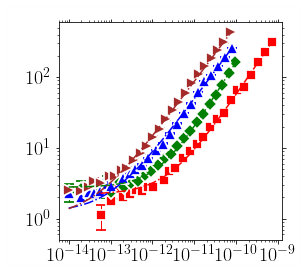

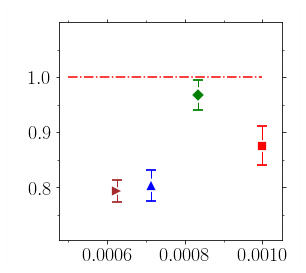

In [10]:
def main():
    if eval(confParser['flags']['RemoteMachine']):
        return
    !mkdir png
    colorIndices=[1,2,3,5]
    temp = Temperature(
#        [1000,1200,1400,1600,1800,2000],[list(range(1))]*10,
        colorIndices,[list(range(1))]*10,
                     )
    #
#    temp.Parse( list(map(lambda x:'ni/FoilesPotential/temp%s/msd/Run%s/png/msd.txt'%(x[0],x[1]),
#    temp.Parse( list(map(lambda x:'nicocr/kmc/NiCoCrNatom1KTemp%sK/msd/Run%s/png/msd_total.txt'%(x[0],x[1]),
    temp.Parse( list(map(lambda x:'cantorNatom1K/multipleTemp/temp%s/msd/Run%s/png/msd.txt'%(x[0],x[1]),
                         temp.temps_runs ))
             )
#     temp.Plot(     colorIndices,**{
#                   'xscale':'log',
#                   'yscale':'log',
#                    'attrs':{'fmt':'-'},
# #                   'xlim':xlim,
# #                      'ylim':ylim,
# #                    'title':'png/msd_temp_ni.png',
#                     'xstr':r'$t(\mathrm{s})$','ystr':r'$\mathrm{msd}(\r{A}^2)$',
#         'bbox_to_anchor':(0.01,0.3,0.5,0.5)
#     })
    temp.EnsAverage(
                   )
    temp.Fit(Plot=True,
              #Rescale=True,
            p0=[[1e1, 1e10, 1.0]],
               sigma=True, #--- comment for ni
              xlo=[1e-14]*6, xhi=[8e-10,1e-10,1e-10,1e-10], #[1e-9,5.5e-10,5e-10,1e-10],  #
             colorIndices=colorIndices,
             Labels=['1000','1200','1400','1600','1800','2000'],
             plotAttrs={'yscale':'log',
                  'xscale':'log',
                        'ndecade_x':1,
                    'bbox_to_anchor':(-0.05,0.42,0.5,0.5),
                     'title':'png/msd_temp_cantor_fit_vac.png',
                       }
            )
    temp.PlotExponent(np.linspace(1000,2000,6),
                      colorIndices=colorIndices,
                      **{
                    'title':'png/alpha_temp_ni.png',
                    #'ylim':(0.8,1.2),
                    }
                )
    return temp

temp = main()
#exp = np.c_[[[temp.exponent[key][0], temp.exponent[key][1]-temp.exponent[key][2]] for key in temp.temps]]
#np.savetxt('msd/cantor.txt',exp,header='2H err')

In [ ]:
def main():
    if eval(confParser['flags']['RemoteMachine']):
        return
    
    symbols=Symbols()
    legend = Legends()
    legend.Set(labelspacing=.5,fontsize=16,
                bbox_to_anchor=(0.4,0.0,0.5,0.5))

    temps = [1000,1200,1400,1600,1800,2000]
    colorIndices=[0,1,2,3,4,5]

    data_ni = np.loadtxt('msd/ni_total.txt')
    data_nicocr = np.loadtxt('msd/nicocr_total.txt')
    data_cantor = np.loadtxt('msd/cantor_total.txt')

    ax = utl.PltErr(None,None,Plot=False)

    #for item,T, indx in zip(data_ni,temps,colorIndices):
    utl.PltErr(np.array(temps),data_ni[:,0],
               yerr=data_ni[:,1],
               attrs=symbols.GetAttrs(count=0,label='$\mathrm{Ni}$'),
              Plot=False,
               ax=ax
              )

    utl.PltErr(np.array(temps),data_nicocr[:,0],
               yerr=data_nicocr[:,1],
               attrs=symbols.GetAttrs(count=1,label='$\mathrm{NiCoCr}$'),
              Plot=False,
               ax=ax
              )

    temps = [1200,1400,1600,2000]
    utl.PltErr(np.array(temps),data_cantor[:,0],
               yerr=data_cantor[:,1],
               attrs=symbols.GetAttrs(count=2,label='$\mathrm{NiCoCrFeMn}$'),
              Plot=False,
               ax=ax
              )

    utl.PltErr(None,None,ax=ax,
              ylim=(0.75,1.05),
               xticks=(['$1000$','$1200$','$1400$','$1600$','$1800$','$2000$'],[1000,1200,1400,1600,1800,2000]),
               legend=legend.Get(),
               title='png/hurst_total.png',
               fontsize=18,
                           DrawFrame=DRAW_FRAME,
              )
    
main()

In [ ]:
def main():
    if eval(confParser['flags']['RemoteMachine']):
        return
    symbols=Symbols()
    legend = Legends()
    legend.Set(labelspacing=.5,fontsize=16,
                bbox_to_anchor=(0.1,0.48,0.5,0.5))

    temps = [1000,1200,1400,1600,1800,2000]
    colorIndices=[0,1,2,3,4,5]

    data_ni = np.loadtxt('msd/ni.txt')
    data_nicocr = np.loadtxt('msd/nicocr.txt')
    data_cantor = np.loadtxt('msd/cantor.txt')

    ax = utl.PltErr(None,None,Plot=False)

    #for item,T, indx in zip(data_ni,temps,colorIndices):
    utl.PltErr(np.array(temps),data_ni[:,0],
               yerr=data_ni[:,1],
               attrs=symbols.GetAttrs(count=0,label='$\mathrm{Ni}$'),
              Plot=False,
               ax=ax
              )

    utl.PltErr(np.array(temps),data_nicocr[:,0],
               yerr=data_nicocr[:,1],
               attrs=symbols.GetAttrs(count=1,label='$\mathrm{NiCoCr}$'),
              Plot=False,
               ax=ax
              )

    temps = [1200,1400,1600,2000]
    utl.PltErr(np.array(temps),data_cantor[:,0],
               yerr=data_cantor[:,1],
               attrs=symbols.GetAttrs(count=2,label='$\mathrm{NiCoCrFeMn}$'),
              Plot=False,
               ax=ax
              )

    utl.PltErr(None,None,ax=ax,
              ylim=(0.75,1.05),
               xticks=(['$1000$','$1200$','$1400$','$1600$','$1800$','$2000$'],[1000,1200,1400,1600,1800,2000]),
    #            legend=legend.Get()
               title='png/hurst.png',
               fontsize=18,
                           DrawFrame=DRAW_FRAME,
              )
main()

In [ ]:
def main():
    if eval(confParser['flags']['RemoteMachine']):
        return
    !mkdir png
    #--- temp object
    temp = Temperature(
        ['shengPotential/temp0_vac','FoilesPotential/temp0'],[list(range(1))]*10,
#           verbose = True,
                     )
    #
    temp.Parse( list(map(lambda x:'vacancy/%s/Run%s/png/msd.txt'%(x[0],x[1]),
                         temp.temps_runs ))
             )
    #
    #--- plot
#    xlim = (1e-15,1e-10)
#    ylim = (1e-1,1e3)
    print('single realizations')
    temp.Plot(**{
                  'xscale':'log',
                  'yscale':'log',
                   'attrs':{'fmt':'-'},
#                   'xlim':xlim,
#                      'ylim':ylim,
#                    'title':'png/msd_temp_ni.png',
                    'xstr':r'$t(\mathrm{s})$','ystr':r'$\mathrm{msd}(\r{A}^2)$',
        'bbox_to_anchor':(0.01,0.3,0.5,0.5)
    })
    
    temp.EnsAverage(
                   )
    
    filtr = temp.data[0][:,0]<=.8e-6
    temp.data[0] = temp.data[0][filtr]
    filtr = temp.data[1][:,0]<=1.4e-6
    temp.data[1] = temp.data[1][filtr]
    
    #
    #--- fit
    #
    temp.Fit2nd(Plot=True,
#              shift=True,
            p0=[[1e0, 1e10, 1.0]],
               sigma=True, #--- comment for ni
              xlo=[1e-15]*6, xhi=[2e-8,1.4e-6],
             colorIndices=[0,1,2,3,4,5],
             Labels=['1000','1200','1400','1600','1800','2000'],
                nevery=2,
             plotAttrs={'yscale':'log',
                  'xscale':'log',
#                    'xlim':xlim,
#                       'ylim':ylim,
                        'ndecade_x':1,
                    'bbox_to_anchor':(0.36,0.42,0.5,0.5),
                     'xstr':r'$t(\mathrm{s})$','ystr':r'$\mathrm{msd}_v(\r{A}^2)$',
#                         'fontsize':24,
                     'title':'png/msd_temp_ni_fit_vac.png',
#              'halfopen':True
                       }
            )



    temp.PlotExponent(np.linspace(1000,2000,6),
                      colorIndices=[0,1,2,3,4,5],
                      **{
                    'title':'png/alpha_temp_ni.png',
                    'ylim':(0.5,1.5),
                    }
                )
    
    return temp

temp = main()

#### linear scales

In [ ]:
def main():
    if eval(confParser['flags']['RemoteMachine']):
        return
    !mkdir png
    
#    Tmax = [2e-6,2e-7,8e-8,2e-8,1e-8,4e-9][0]
#    Tmax = [1e-7,2e-9,1e-9,6e-10,3.2e-10,2e-10][5]
    colorIndices=[5]
    Tmax = [1e7,2e-9,4e-10,3e-10,1e7,8e-11][5]
    temp = Temperature( ['cantorNatom1K/multipleTemp/temp5'],[list(range(1))]*10, verbose=True)
#    labels=[r'$\mathrm{Ni}$',r'$\mathrm{NiCoCr}$',r'$\mathrm{NiCoCrFeMn}$']
#    temp = Temperature( ['ni/FoilesPotential/temp1','nicocr/kmc/NiCoCrNatom1KTemp1200K','cantorNatom1K/multipleTemp/temp1'],[list(range(8)),list(range(8)),list(range(8))]*10)

    #
    temp.Parse( list(map(lambda x:'%s/msd/Run%s/png/msd_total_lin.txt'%(x[0],x[1]),
                         temp.temps_runs )))
    
    for indx, tmax in zip([0],[Tmax]):
        time = temp.data[indx][:,0]
        filtr = time <= tmax
        temp.data[indx] =  temp.data[indx][filtr]

        time = temp.data[indx][:,0]
        time *= 1e6
#         y = temp.data[indx][:,1]
#         yerr = temp.data[indx][:,2]
#         yerr /= np.max(y) 
#         y /= np.max(y)
#         time /= np.max(time)
        temp.data[indx][:,0] = time
#         temp.data[indx][:,1] = y
#         temp.data[indx][:,2] = yerr
    
    temp.Plot(     colorIndices,['junk'],**{#'xscale':'log','yscale':'log',
#                   'xlim':xlim,
#                      'ylim':ylim,
                    'title':'png/msd_temp_cantor_T2000K.png',
#                     'xstr':r'$t(\mu\mathrm{s})$','ystr':r'$\mathrm{msd}(\r{A}^2)$',
        'bbox_to_anchor':(0.01,0.3,0.5,0.5)
    })
    return temp

temp = main()


#### types

mkdir: png: File exists


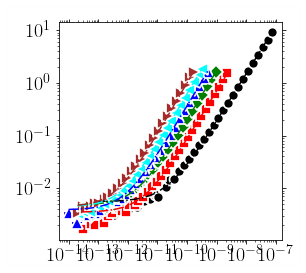

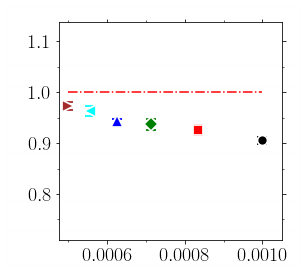

In [14]:
def main():
    if eval(confParser['flags']['RemoteMachine']):
        return
    !mkdir png
    colorIndices=[0,1,2,3,4,5]
    temp = Temperature(
        [1000,1200,1400,1600,1800,2000],[list(range(1))]*10,
#        colorIndices,[list(range(1))]*10,
                     )
    #
#    temp.Parse( list(map(lambda x:'ni/FoilesPotential/temp%s/msd/Run%s/png/msd.txt'%(x[0],x[1]),
    temp.Parse( list(map(lambda x:'nicocr/kmc/NiCoCrNatom1KTemp%sK/msd/Run%s/png/msd_total.txt'%(x[0],x[1]),
#    temp.Parse( list(map(lambda x:'cantorNatom1K/multipleTemp/temp%s/msd/Run%s/png/msd.txt'%(x[0],x[1]),
                         temp.temps_runs ))
             )
#     temp.Plot(     colorIndices,**{
#                   'xscale':'log',
#                   'yscale':'log',
#                    'attrs':{'fmt':'-'},
# #                   'xlim':xlim,
# #                      'ylim':ylim,
# #                    'title':'png/msd_temp_ni.png',
#                     'xstr':r'$t(\mathrm{s})$','ystr':r'$\mathrm{msd}(\r{A}^2)$',
#         'bbox_to_anchor':(0.01,0.3,0.5,0.5)
#     })
    temp.EnsAverage(
                   )
    temp.Fit(Plot=True,
              #Rescale=True,
            p0=[[1e1, 1e10, 1.0]],
               sigma=True, #--- comment for ni
              xlo=[1e-14]*6, xhi=[1e1]*6,  
             colorIndices=colorIndices,
             Labels=['1000','1200','1400','1600','1800','2000'],
             plotAttrs={'yscale':'log',
                  'xscale':'log',
                        'ndecade_x':1,
                    'bbox_to_anchor':(-0.05,0.42,0.5,0.5),
                     'title':'png/msd_temp_cantor_fit_vac.png',
                       }
            )
    temp.PlotExponent(np.linspace(1000,2000,6),
                      colorIndices=colorIndices,
                      **{
                    'title':'png/alpha_temp_ni.png',
                    #'ylim':(0.8,1.2),
                    }
                )
    return temp

temp = main()
#exp = np.c_[[[temp.exponent[key][0], temp.exponent[key][1]-temp.exponent[key][2]] for key in temp.temps]]
#np.savetxt('msd/cantor.txt',exp,header='2H err')

#### ml

In [ ]:
def main():
    if eval(confParser['flags']['RemoteMachine']):
        return
    !mkdir png
    temp = Temperature(
        [0],[list(range(8))]*10,
                     )
    #
    temp.Parse( list(map(lambda x:'ni/void_2d/msd/Run%s/png/msd.txt'%(x[1]),
                         temp.temps_runs ))
             )
#     temp.Plot(     colorIndices,**{
#                   'xscale':'log',
#                   'yscale':'log',
#                    'attrs':{'fmt':'-'},
# #                   'xlim':xlim,
# #                      'ylim':ylim,
# #                    'title':'png/msd_temp_ni.png',
#                     'xstr':r'$t(\mathrm{s})$','ystr':r'$\mathrm{msd}(\r{A}^2)$',
#         'bbox_to_anchor':(0.01,0.3,0.5,0.5)
#     })
    temp.EnsAverage(
                   )
    temp.Fit(Plot=True,
              #Rescale=True,
            p0=[[1e1, 1e10, 1.0]],
               sigma=True, #--- comment for ni
              xlo=[1e-14]*6, xhi=[sys.maxsize], #[1e-9,5.5e-10,5e-10,1e-10],  #
             colorIndices=[0],
             Labels=['1000','1200','1400','1600','1800','2000'],
             plotAttrs={'yscale':'log',
                  'xscale':'log',
                        'ndecade_x':1,
                    'bbox_to_anchor':(-0.05,0.42,0.5,0.5),
                     'title':'png/msd_temp_cantor_fit_vac.png',
                       }
            )
    temp.PlotExponent(np.linspace(1000,2000,6),
                      colorIndices=[0],
                      **{
                    'title':'png/alpha_temp_ni.png',
                    #'ylim':(0.8,1.2),
                    }
                )
    return temp

# temp = main()


### Correlation Factor

In [ ]:
def main(input_file0,input_file1,fout):
    if not eval(confParser['Vacancy Dynamics']['CorrelationFactor']):
        return

    !mkdir png
    path       = confParser['Vacancy Dynamics']['input_path']
    nruns      = eval(confParser['Vacancy Dynamics']['nruns'])
    
    
    
    #--- msd vs kmc jump
    temp_vac = Temperature( [0],[list(range(nruns))]*100,verbose = True)
    temp_vac.Parse( list(map(lambda x:'%s/Run%s/msd/%s'%(path,x[1],input_file0),
                          temp_vac.temps_runs )))
    temp_vac.EnsAverage3rd(
                             n_thresh=10,
                            )
    n_jumps = temp_vac.data_averaged[0][:,0]
    msd     = temp_vac.data_averaged[0][:,1]
    yerr    = temp_vac.data_averaged[0][:,2]    

    

    
    #--- variance corresponding to jumps
    temp = Temperature(
        [0],[list(range(nruns))]*100,verbose = True)
    temp.Parse( list(map(lambda x:'%s/Run%s/msd/%s'%(path,x[1],input_file1),
                          temp.temps_runs )))
    temp.EnsAverage3rd(
                           n_thresh=10,
                            ReturnConcat=True
                          )
    
    # compute variance
    xdata = temp.data_averaged[0][:,0]
    ydata = temp.data_averaged[0][:,1]
    zdata = temp.data_averaged[0][:,2]
    var   = np.var( xdata ) + np.var( ydata ) + np.var( zdata )
    dvar  = var * np.sqrt( 2.0 / len( xdata ) )
    
    print('msd[0] =? var', msd[0],var)
    
    correlation_factor = msd  / n_jumps / var 
    relative_err       = yerr / msd - dvar / var 
    
    np.savetxt(fout,np.c_[n_jumps,correlation_factor,relative_err*correlation_factor],header='n cf err')

# main(
#     confParser['Vacancy Dynamics']['input_file_total'],
#     confParser['Vacancy Dynamics']['input_jumps_total'],
#     'png/cf_total.txt',                
#        )

main(
    confParser['Vacancy Dynamics']['input_file_vacancy'],
    confParser['Vacancy Dynamics']['input_jumps_vacancy'],
    'png/cf_vacancy.txt',                
       )


#### Plot

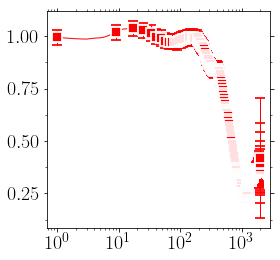

In [146]:
def main():
    if eval(confParser['flags']['RemoteMachine']):
        return

    path = 'png'
#    data_total = np.loadtxt('%s/cf_total.txt'%path)
    data_vac   = np.loadtxt('%s/cf_vacancy.txt'%path)
    
    symbols=utl.Symbols()
    ax = utl.PltErr(None,None,Plot=False)
#    print(data_vac)
#     utl.PltErr( data_total[:,0],data_total[:,1],
#               yerr=data_total[:,2],
#                attrs=symbols.GetAttrs(count=0,nevery=200),
#                Plot=False,
#                ax=ax
#               )

    utl.PltErr( data_vac[:,0],data_vac[:,1],
              yerr=2*data_vac[:,2],
               attrs=symbols.GetAttrs(count=1,nevery=8),
               Plot=False,
               ax=ax
              )
    
    utl.PltErr(None,None,
              xscale='log',
#              yscale='log',
#               ylim=(0.7,1.3),
#               xlim=(1e3,2e3),
               ax=ax,
              )
main()

In [147]:
# def rndWalk(nstep):
#     print('rndWalk ...')
#     size=nstep+1
#     vel=np.random.normal(size=nstep*3).reshape((nstep,3))
#     x=np.cumsum(vel,axis=0)
#     x = np.c_[[0,0,0],x.T].T

#     count = 0
#     xij=np.zeros(int(size*(size-1)/2))
#     yij=np.zeros(int(size*(size-1)/2))
#     zij=np.zeros(int(size*(size-1)/2))
#     tij=np.zeros(int(size*(size-1)/2))
#     number=np.zeros(int(size*(size-1)/2))
#     for i in range(nstep+1):
#         for j in range(i+1,nstep+1):
#             xij[count] = x[j,0] - x[i,0]
#             yij[count] = x[j,1] - x[i,1]
#             zij[count] = x[j,2] - x[i,2]
#             tij[count] = j - i
#             number[count]=1
#             count += 1

#     with open('Run0/msd/vacancy_jumps.txt','a') as fp:
#         np.savetxt(fp,vel)

#     return np.c_[tij, xij,yij,zij,xij*xij,yij*yij,zij*zij,number, tij]

# nstep = 2000
# n_sample = 8

# !rm  Run0/msd/vacancy_jumps.txt
# tr_mat    = np.concatenate(list(map(lambda x:rndWalk(nstep),range(n_sample))))
# !rm -r Run0/msd/dt_dx.txt
# with open('Run0/msd/dt_dx.txt','w') as fp:
#      np.savetxt(fp,tr_mat,header='dt dx dy dz dx_sq dy_sq dz_sq number n_jumps')

# print(tr_mat.shape)


rndWalk ...
rndWalk ...
rndWalk ...
rndWalk ...
rndWalk ...
rndWalk ...
rndWalk ...
rndWalk ...
(16008000, 9)


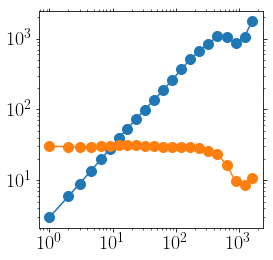

<AxesSubplot:>

In [145]:
# data = np.loadtxt('png/msd.txt')

# ax=utl.PltErr(data[:,0],data[:,1],yerr=data[:,2],
#           xscale='log',yscale='log',Plot=False
#           )
# utl.PltErr(data[:,0],10*data[:,1]/data[:,0],yerr=data[:,2]/data[:,0],
#           xscale='log',yscale='log',ax=ax
#           )
